In [16]:
import pandas as pd
import numpy as np
import sys
import os
import xgboost_model

# Data Loading
import ccxt
import pandas as pd

import portfolio

# Technical Indicators 
from datetime import datetime, timedelta
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler

# MODULE : MODEL LIBRARIES
# all libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV, gp_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
import numpy as np

# Plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
curr_dir = os.getcwd()
file_path = os.path.join(curr_dir, "data/processed.csv")
btc_data = pd.read_csv(file_path)

In [11]:
print(btc_data.head())

   Unnamed: 0  timestamp      open      high       low     close       volume  \
0           0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903   
1           1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661   
2           2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173   
3           3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334   
4           4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327   

      SMA_5     SMA_10        SMA_15  ...  close_1_ahead  close_2_ahead  \
0  44053.58  44788.027  44272.906667  ...       44946.91       42845.23   
1  44053.58  44788.027  44272.906667  ...       42845.23       44151.10   
2  44053.58  44788.027  44272.906667  ...       44151.10       44145.11   
3  44053.58  44788.027  44272.906667  ...       44145.11       43968.32   
4  44053.58  44788.027  44272.906667  ...       43968.32       43929.02   

   close_5_ahead  close_7_ahead  close_10_ahead  close_15_ahea

In [12]:
print(btc_data.columns)

Index(['Unnamed: 0', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'SMA_5', 'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10',
       'ATR_14', 'upper_band', 'lower_band', 'daily_momentum',
       'rolling_mean_3', 'rolling_std_3', 'close_lag_1', 'close_lag_2',
       'close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_7_ahead',
       'close_10_ahead', 'close_15_ahead', 'close_20_ahead', 'close_30_ahead',
       'log_return', 'return_1'],
      dtype='object')


In [6]:
data = btc_data

data['timestamp'] = pd.to_datetime(data['timestamp'])
# Features and target
features = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2']
targets = ['close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead', 'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'return_1']

#define date range correctly
train_end_date = pd.to_datetime('2025-01-01') 
val_end_date = pd.to_datetime('2025-02-28')
test_end_date = pd.to_datetime('2025-03-01')

# Split the data
train_data = data[data['timestamp'] < train_end_date]
val_data = data[(data['timestamp'] >= train_end_date) & (data['timestamp'] <= val_end_date)]
test_data = data[(data['timestamp'] >= val_end_date)]



# Split into X & y 
X_train = train_data[features].drop(columns = ['timestamp'])
X_val = val_data[features].drop(columns = ['timestamp'])
X_test = test_data[features].drop(columns = ['timestamp'])


y_train = train_data[targets]
y_val = val_data[targets]
y_test = test_data[targets]


In [7]:
print(data.head())

   Unnamed: 0  timestamp      open      high       low     close       volume  \
0           0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903   
1           1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661   
2           2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173   
3           3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334   
4           4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327   

      SMA_5     SMA_10        SMA_15  ...  close_1_ahead  close_2_ahead  \
0  44053.58  44788.027  44272.906667  ...       44946.91       42845.23   
1  44053.58  44788.027  44272.906667  ...       42845.23       44151.10   
2  44053.58  44788.027  44272.906667  ...       44151.10       44145.11   
3  44053.58  44788.027  44272.906667  ...       44145.11       43968.32   
4  44053.58  44788.027  44272.906667  ...       43968.32       43929.02   

   close_5_ahead  close_7_ahead  close_10_ahead  close_15_ahea

=== Phase 1: Feature Selection ===
Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14', 'upper_band',
       'lower_band', 'daily_momentum', 'rolling_mean_3', 'rolling_std_3',
       'close_lag_1', 'close_lag_2'],
      dtype='object')
Removed 0 low-variance features
Feature importances:
close             0.376984
open              0.323589
SMA_10            0.151338
SMA_15            0.065753
high              0.056762
low               0.008072
close_lag_2       0.003709
rolling_mean_3    0.002624
upper_band        0.002280
SMA_5             0.001148
daily_momentum    0.001110
MACD              0.001043
OBV               0.001019
rolling_std_3     0.000841
RSI               0.000737
volume            0.000697
EMA_9             0.000611
MFI_10            0.000580
ATR_14            0.000579
lower_band        0.000418
close_lag_1       0.000107
dtype: float32


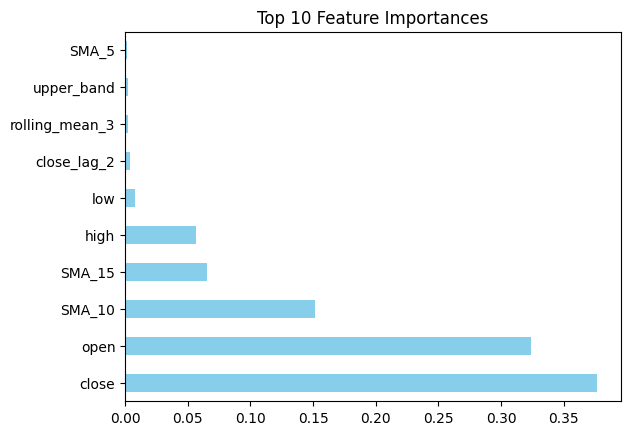


Selected 10 features:
['close', 'open', 'SMA_10', 'SMA_15', 'high', 'low', 'close_lag_2', 'rolling_mean_3', 'upper_band', 'SMA_5']

=== Phase 2: Hyperparameter Optimization ===


ValueError: Found input variables with inconsistent numbers of samples: [59, 34]

In [17]:
final_model_1, y_train_pred_1, y_val_pred_1, y_test_pred_1 = xgboost_model.bayes_xg_boost(X_train, X_val, X_test, y_train, y_val, y_test,'close_1_ahead')
final_model_2, y_train_pred_2, y_val_pred_2, y_test_pred_2 = xgboost_model.bayes_xg_boost(X_train, X_val, X_test, y_train, y_val, y_test, 'close_2_ahead')
final_model_5, y_train_pred_5, y_val_pred_5, y_test_pred_5 = xgboost_model.bayes_xg_boost(X_train, X_val, X_test, y_train, y_val, y_test, 'close_5_ahead')
final_model_10, y_train_pred_10, y_val_pred_10, y_test_pred_10 = xgboost_model.bayes_xg_boost(X_train, X_val, X_test, y_train, y_val, y_test, 'close_10_ahead')
final_model_20, y_train_pred_20, y_val_pred_20, y_test_pred_20 = xgboost_model.bayes_xg_boost(X_train, X_val, X_test, y_train, y_val, y_test, 'close_20_ahead')
final_model_30, y_train_pred_30, y_val_pred_30, y_test_pred_30 = xgboost_model.bayes_xg_boost(X_train, X_val, X_test, y_train, y_val, y_test, 'close_30_ahead')

prediction = final_model_30.predict()

In [ ]:
portfolio = portfolio.Portfolio()
